(1460, 81)
Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 

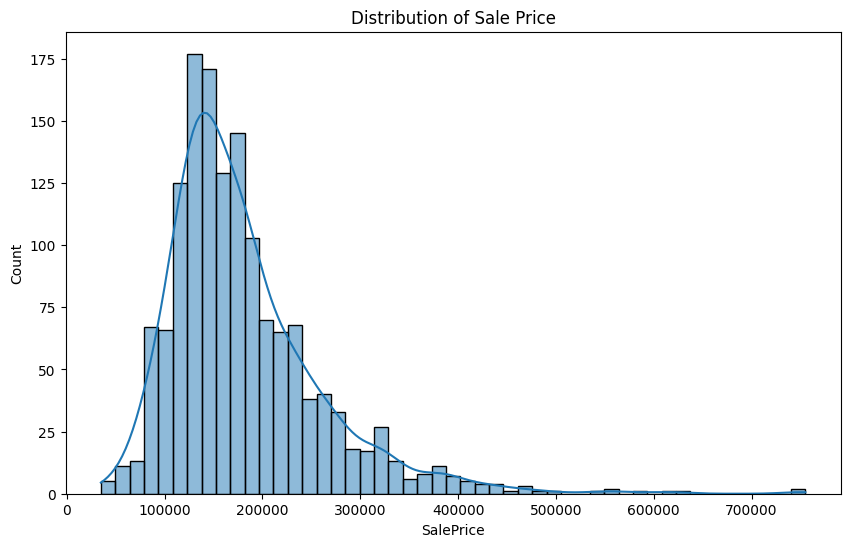

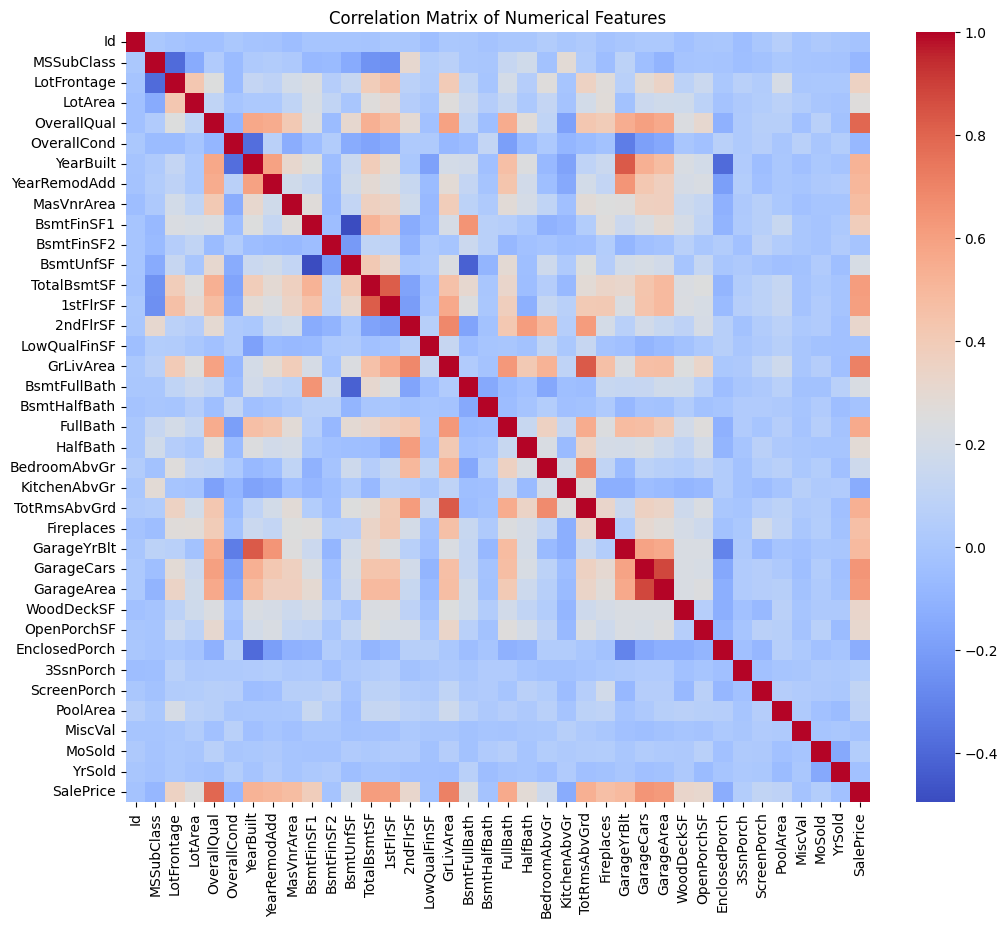

Random Forest RMSE: 0.14562268783056206
XGBoost RMSE: 0.14639269639689392


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb

# Load the data
train_data = pd.read_csv('D:/University/4th Sem/PAI(LAB)/home-data-for-ml-course/train.csv', dtype={'Id': int})
test_data = pd.read_csv('D:/University/4th Sem/PAI(LAB)/home-data-for-ml-course/test.csv', dtype={'Id': int})

def convert_id_to_int(df):
    df['Id'] = df['Id'].astype(int)
    return df

train_data = convert_id_to_int(train_data)
test_data = convert_id_to_int(test_data)


# Basic data exploration
print(train_data.shape)
print(train_data.columns)
print(train_data.dtypes)
print(train_data.describe())

# Check for missing values
print(train_data.isnull().sum().sort_values(ascending=False))

# Visualize the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(train_data['SalePrice'], kde=True)
plt.title('Distribution of Sale Price')
plt.show()

# Correlation matrix of numerical features
numeric_features = train_data.select_dtypes(include=[np.number])
correlation_matrix = numeric_features.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Function to preprocess data
def preprocess_data(data):
    # Separate numeric and non-numeric columns
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    non_numeric_cols = data.select_dtypes(exclude=[np.number]).columns
    
    # Handle missing values for numeric columns
    imputer_numeric = SimpleImputer(strategy='median')
    data_numeric_imputed = pd.DataFrame(imputer_numeric.fit_transform(data[numeric_cols]), columns=numeric_cols)
    
    # Handle missing values for non-numeric columns
    imputer_non_numeric = SimpleImputer(strategy='most_frequent')
    data_non_numeric_imputed = pd.DataFrame(imputer_non_numeric.fit_transform(data[non_numeric_cols]), columns=non_numeric_cols)
    
    # Combine the imputed numeric and non-numeric data
    data_imputed = pd.concat([data_numeric_imputed, data_non_numeric_imputed], axis=1)
    
    # Encode categorical variables
    data_encoded = pd.get_dummies(data_imputed)
    
    # Scale numerical features
    scaler = StandardScaler()
    data_scaled = pd.DataFrame(scaler.fit_transform(data_encoded), columns=data_encoded.columns)
    
    return data_scaled

# Preprocess the data
X = train_data.drop('SalePrice', axis=1)
y = np.log(train_data['SalePrice']) 
X_processed = preprocess_data(X)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions and evaluate
rf_predictions = rf_model.predict(X_val)
rf_rmse = np.sqrt(mean_squared_error(y_val, rf_predictions))
print(f"Random Forest RMSE: {rf_rmse}")

# Train an XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions and evaluate
xgb_predictions = xgb_model.predict(X_val)
xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_predictions))
print(f"XGBoost RMSE: {xgb_rmse}")

# Prepare submission
test_processed = preprocess_data(test_data)

# Align the columns of the test data to match the training data
missing_cols = set(X_processed.columns) - set(test_processed.columns)
for c in missing_cols:
    test_processed[c] = 0
test_processed = test_processed[X_processed.columns]

final_predictions = np.exp(xgb_model.predict(test_processed))  

submission = pd.DataFrame({'Id': test_data['Id'].astype(int), 'SalePrice': final_predictions})
submission.to_csv('submission.csv', index=False)

